# 1. Imports and Device Configuration

In [1]:
# Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from tqdm import tqdm
import os
import math
import random

import torch.nn.functional as F  # For activation functions


In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')


Using device: cuda


# 2. Hyperparameters Setup

Define all hyperparameters in a centralized manner for easy modification. This includes parameters for training from scratch and fine-tuning pre-trained models.

In [3]:
# Hyperparameters for Training from Scratch
scratch_hyperparams = {
    'epochs': 20,          # Number of training epochs
    'alpha': 2,            # LoRA alpha parameter
    'ranks': [0, 2, 4, 8], # List of ranks to experiment with (0 means no LoRA)
    'learning_rate': 1e-3  # Learning rate
}

# Hyperparameters for Fine-tuning Pre-trained Models
finetune_hyperparams = {
    'epochs': 10,          # Number of training epochs
    'alpha': 2,            # LoRA alpha parameter
    'ranks': [0, 2, 4, 8], # List of ranks to experiment with (0 means no LoRA)
    'learning_rate': 1e-4  # Learning rate
}


# 3. Data Loading and Preprocessing

Load the CIFAR10 dataset, apply necessary transformations, and create DataLoaders for training, validation, and testing.

In [4]:
# Define transformations for the training and validation sets
transform = transforms.Compose([
    transforms.Resize((64, 64)),          # Resize images to 64x64
    transforms.ToTensor(),                # Convert images to tensor
    transforms.Normalize((0.5, 0.5, 0.5), # Normalize RGB channels
                         (0.5, 0.5, 0.5))
])

# Download and prepare the CIFAR10 dataset
dataset = datasets.CIFAR10(root='data', train=True, download=True, transform=transform)

# Split into train and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Prepare the test set
test_dataset = datasets.CIFAR10(root='data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f'Train samples: {len(train_dataset)}, Validation samples: {len(val_dataset)}, Test samples: {len(test_dataset)}')


Files already downloaded and verified
Files already downloaded and verified
Train samples: 40000, Validation samples: 10000, Test samples: 10000


# 4. LoRA Implementation

Implement the LoRA (Low-Rank Adaptation) module, which modifies existing linear layers to include low-rank adaptations.

In [5]:
class LoRA(nn.Module):
    def __init__(self, original_module, rank=4, alpha=1):
        """
        LoRA module for adapting existing linear layers with low-rank matrices.
        
        Args:
            original_module (nn.Module): The original linear layer to adapt.
            rank (int): The rank of the low-rank matrices.
            alpha (int): The scaling factor.
        """
        super(LoRA, self).__init__()
        self.original_module = original_module
        self.rank = rank
        self.alpha = alpha

        # Assuming original_module is a Linear layer
        self.lora_A = nn.Linear(original_module.in_features, rank, bias=False)
        self.lora_B = nn.Linear(rank, original_module.out_features, bias=False)
        self.scaling = self.alpha / self.rank

        # Initialize LoRA weights
        nn.init.kaiming_uniform_(self.lora_A.weight, a=math.sqrt(5))
        nn.init.zeros_(self.lora_B.weight)

    def forward(self, x):
        return self.original_module(x) + self.scaling * self.lora_B(self.lora_A(x))


# 5. Model Definitions

Define the SimpleCNN model for training from scratch and a function to get the pre-trained ResNet18 model with optional LoRA adaptation.

In [6]:
class SimpleCNN(nn.Module):
    def __init__(self, use_lora=False, lora_rank=4, lora_alpha=1):
        """
        A simple CNN model with optional LoRA adaptation on the first fully connected layer.
        
        Args:
            use_lora (bool): Whether to apply LoRA to the first fully connected layer.
            lora_rank (int): The rank parameter for LoRA.
            lora_alpha (int): The alpha parameter for LoRA.
        """
        super(SimpleCNN, self).__init__()
        self.use_lora = use_lora
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, 10)

        if self.use_lora:
            self.fc1 = LoRA(self.fc1, rank=lora_rank, alpha=lora_alpha)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)  # Output size: 32x32
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)  # Output size: 16x16
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [7]:
def get_pretrained_model(use_lora=False, lora_rank=4, lora_alpha=1, num_classes=10):
    """
    Loads a pre-trained ResNet18 model, replaces the final fully connected layer,
    and optionally applies LoRA to it.
    
    Args:
        use_lora (bool): Whether to apply LoRA to the final layer.
        lora_rank (int): The rank parameter for LoRA.
        lora_alpha (int): The alpha parameter for LoRA.
        num_classes (int): The number of output classes.
    
    Returns:
        nn.Module: The modified ResNet18 model.
    """
    # Load pre-trained ResNet18 without modifying num_classes
    model = models.resnet18(pretrained=True)
    
    # Get the number of input features for the existing final layer
    num_ftrs = model.fc.in_features
    
    # Replace the final layer with a new one
    model.fc = nn.Linear(num_ftrs, num_classes)
    
    if use_lora:
        # Apply LoRA to the newly replaced final layer
        model.fc = LoRA(model.fc, rank=lora_rank, alpha=lora_alpha)
    
    return model.to(device)


# 6. Callback Implementations

Implement callback classes for early stopping, model checkpointing, and learning rate scheduling to enhance the training process.

In [8]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        """
        Early stops the training if validation loss doesn't improve after a given patience.
        
        Args:
            patience (int): How long to wait after last time validation loss improved.
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
        """
        self.patience = patience
        self.delta = delta
        self.best_loss = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
            return
        elif val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True


In [9]:
class ModelCheckpoint:
    def __init__(self, save_path='best_model.pth'):
        """
        Saves the model when validation loss decreases.
        
        Args:
            save_path (str): Path to save the best model.
        """
        self.best_loss = float('inf')
        self.save_path = save_path

    def __call__(self, model, val_loss):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            torch.save(model.state_dict(), self.save_path)
            print(f'Best model saved with loss: {val_loss:.4f}')


In [10]:
class LearningRateScheduler:
    def __init__(self, optimizer, mode='min', factor=0.1, patience=3, verbose=True):
        """
        Decays the learning rate of each parameter group by a factor of 0.1 if validation loss doesn't improve.
        
        Args:
            optimizer (Optimizer): Wrapped optimizer.
            mode (str): One of 'min' or 'max'. In 'min' mode, lr will be reduced when the quantity monitored has stopped decreasing.
            factor (float): Factor by which the learning rate will be reduced.
            patience (int): Number of epochs with no improvement after which learning rate will be reduced.
            verbose (bool): If True, prints a message to stdout for each update.
        """
        self.optimizer = optimizer
        self.mode = mode
        self.factor = factor
        self.patience = patience
        self.verbose = verbose
        self.best = None
        self.num_bad_epochs = 0

    def step(self, current_loss):
        if self.best is None:
            self.best = current_loss
            return

        if self.mode == 'min':
            if current_loss < self.best:
                self.best = current_loss
                self.num_bad_epochs = 0
            else:
                self.num_bad_epochs += 1
        elif self.mode == 'max':
            if current_loss > self.best:
                self.best = current_loss
                self.num_bad_epochs = 0
            else:
                self.num_bad_epochs += 1
        else:
            raise ValueError("mode should be 'min' or 'max'")

        if self.num_bad_epochs >= self.patience:
            self._reduce_lr()
            self.num_bad_epochs = 0

    def _reduce_lr(self):
        for param_group in self.optimizer.param_groups:
            old_lr = param_group['lr']
            new_lr = old_lr * self.factor
            param_group['lr'] = new_lr
            if self.verbose:
                print(f'Reducing learning rate from {old_lr} to {new_lr}')


# 7. Metrics Logger

Implement a class to log training and validation metrics for each epoch.

In [11]:
class MetricsLogger:
    def __init__(self):
        """
        Logs training and validation metrics.
        """
        self.history = {
            'train_loss': [],
            'val_loss': [],
            'train_acc': [],
            'val_acc': []
        }

    def log(self, train_loss, val_loss, train_acc, val_acc):
        """
        Logs the metrics for an epoch.
        
        Args:
            train_loss (float): Training loss.
            val_loss (float): Validation loss.
            train_acc (float): Training accuracy.
            val_acc (float): Validation accuracy.
        """
        self.history['train_loss'].append(train_loss)
        self.history['val_loss'].append(val_loss)
        self.history['train_acc'].append(train_acc)
        self.history['val_acc'].append(val_acc)


# 8. Training and Evaluation Functions

Define functions to handle the training loop and model evaluation on the test set.

In [12]:
def train_model(model, train_loader, val_loader, criterion, optimizer, callbacks, num_epochs=25):
    """
    Trains the model with the given parameters and callbacks.
    
    Args:
        model (nn.Module): The neural network model.
        train_loader (DataLoader): DataLoader for training data.
        val_loader (DataLoader): DataLoader for validation data.
        criterion (nn.Module): Loss function.
        optimizer (Optimizer): Optimizer.
        callbacks (dict): Dictionary containing callbacks.
        num_epochs (int): Number of training epochs.
    
    Returns:
        nn.Module: The trained model.
        MetricsLogger: Object containing training and validation metrics.
    """
    metrics_logger = MetricsLogger()
    early_stopping = callbacks.get('early_stopping', None)
    checkpoint = callbacks.get('model_checkpoint', None)
    lr_scheduler = callbacks.get('lr_scheduler', None)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} - Training', leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_train_loss = running_loss / len(train_loader.dataset)
        epoch_train_acc = correct / total

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} - Validation', leave=False):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        epoch_val_loss = val_loss / len(val_loader.dataset)
        epoch_val_acc = val_correct / val_total

        metrics_logger.log(epoch_train_loss, epoch_val_loss, epoch_train_acc, epoch_val_acc)

        print(f'Epoch {epoch+1}/{num_epochs}: '
              f'Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f}, '
              f'Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}')

        # Callbacks
        if checkpoint:
            checkpoint(model, epoch_val_loss)
        if early_stopping:
            early_stopping(epoch_val_loss)
            if early_stopping.early_stop:
                print("Early stopping triggered.")
                break
        if lr_scheduler:
            lr_scheduler.step(epoch_val_loss)

    # Load best model if checkpoint was used
    if checkpoint:
        model.load_state_dict(torch.load(checkpoint.save_path))

    return model, metrics_logger


In [13]:
def evaluate_model(model, test_loader, criterion):
    """
    Evaluates the model on the test set.
    
    Args:
        model (nn.Module): The trained model.
        test_loader (DataLoader): DataLoader for test data.
        criterion (nn.Module): Loss function.
    
    Returns:
        dict: Dictionary containing test loss and accuracy.
    """
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc='Testing', leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            test_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_loss /= len(test_loader.dataset)
    test_acc = correct / total

    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}')
    return {'test_loss': test_loss, 'test_accuracy': test_acc}


# 9. Visualization Functions


Define functions to plot loss curves, accuracy curves, and weight matrix visualizations.

In [14]:
def plot_loss_curves(metrics_logger, title='Loss Curves'):
    """
    Plots training and validation loss curves.
    
    Args:
        metrics_logger (MetricsLogger): Object containing loss histories.
        title (str): Title of the plot.
    """
    try:
        train_loss = metrics_logger.history['train_loss']
        val_loss = metrics_logger.history['val_loss']
        
        if not train_loss or not val_loss:
            print(f"No loss data available for {title}.")
            return
        
        epochs = range(1, len(train_loss) + 1)
        
        plt.figure(figsize=(10, 6))
        plt.plot(epochs, train_loss, label='Train Loss')
        plt.plot(epochs, val_loss, label='Validation Loss')
        plt.title(title)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        plt.show()
    except AttributeError as e:
        print(f"Error: {e}. Ensure that 'metrics_logger' has a 'history' attribute with 'train_loss' and 'val_loss'.")
    except KeyError as e:
        print(f"Error: Missing key {e} in 'metrics_logger.history'.")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")


In [15]:
def plot_accuracy_curves(metrics_logger, title='Accuracy Curves'):
    """
    Plots training and validation accuracy curves.
    
    Args:
        metrics_logger (MetricsLogger): Object containing accuracy histories.
        title (str): Title of the plot.
    """
    try:
        train_acc = metrics_logger.history['train_acc']
        val_acc = metrics_logger.history['val_acc']
        
        if not train_acc or not val_acc:
            print(f"No accuracy data available for {title}.")
            return
        
        epochs = range(1, len(train_acc) + 1)
        
        plt.figure(figsize=(10, 6))
        plt.plot(epochs, train_acc, label='Train Accuracy')
        plt.plot(epochs, val_acc, label='Validation Accuracy')
        plt.title(title)
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True)
        plt.show()
    except AttributeError as e:
        print(f"Error: {e}. Ensure that 'metrics_logger' has a 'history' attribute with 'train_acc' and 'val_acc'.")
    except KeyError as e:
        print(f"Error: Missing key {e} in 'metrics_logger.history'.")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")


In [16]:
def visualize_weight_matrix(model, layer_name='fc1'):
    """
    Visualizes the weight matrix of a specified layer.
    
    Args:
        model (nn.Module): The trained model.
        layer_name (str): Name of the layer to visualize.
    """
    layer = getattr(model, layer_name)
    # If the layer is wrapped with LoRA, access the original module
    if isinstance(layer, LoRA):
        layer = layer.original_module
    weights = layer.weight.data.cpu().numpy()
    plt.figure(figsize=(8, 6))
    sns.heatmap(weights, cmap='viridis')
    plt.title(f'Weight Matrix Heatmap for {layer_name}')
    plt.xlabel('Input Features')
    plt.ylabel('Output Features')
    plt.show()


In [17]:
def plot_singular_values(model, layer_name='fc1'):
    """
    Plots the singular values of the weight matrix of a specified layer.
    
    Args:
        model (nn.Module): The trained model.
        layer_name (str): Name of the layer to analyze.
    """
    layer = getattr(model, layer_name)
    # If the layer is wrapped with LoRA, access the original module
    if isinstance(layer, LoRA):
        layer = layer.original_module
    weights = layer.weight.data.cpu().numpy()
    U, S, V = np.linalg.svd(weights, full_matrices=False)
    plt.figure(figsize=(8, 6))
    plt.plot(S, marker='o')
    plt.title(f'Singular Values of {layer_name} Weight Matrix')
    plt.xlabel('Index')
    plt.ylabel('Singular Value')
    plt.grid(True)
    plt.show()


# 10. Experiment 1: Training from Scratch

Compare normal training vs. training with LoRA on a simple CNN model. After each training run, plot the loss and accuracy curves and evaluate on the test set.

a. Training Function Without LoRA (Baseline)

In [18]:
def train_scratch_model(rank=0, alpha=2, learning_rate=1e-3, epochs=20):
    """
    Trains a SimpleCNN model from scratch, optionally with LoRA.
    
    Args:
        rank (int): LoRA rank. 0 means no LoRA.
        alpha (int): LoRA alpha parameter.
        learning_rate (float): Learning rate.
        epochs (int): Number of training epochs.
    
    Returns:
        dict: Dictionary containing metrics and test results.
    """
    use_lora = rank != 0
    lora_rank = rank if use_lora else None
    lora_alpha = alpha if use_lora else None

    print(f"\n{'LoRA' if use_lora else 'Normal'} Training: Rank={rank}, Alpha={alpha}, Learning Rate={learning_rate}, Epochs={epochs}")
    
    model = SimpleCNN(use_lora=use_lora, lora_rank=lora_rank, lora_alpha=lora_alpha).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Define callbacks
    callbacks = {
        'early_stopping': EarlyStopping(patience=5),
        'model_checkpoint': ModelCheckpoint(save_path=f'best_scratch_rank{rank}.pth'),
        'lr_scheduler': LearningRateScheduler(optimizer, mode='min', factor=0.1, patience=3)
    }

    # Train the model
    trained_model, metrics = train_model(model, train_loader, val_loader, criterion, optimizer, callbacks, num_epochs=epochs)

    # Plot loss and accuracy curves
    plot_loss_curves(metrics, title=f'Loss Curves for {"LoRA" if use_lora else "Normal"} Training (Rank {rank})')
    plot_accuracy_curves(metrics, title=f'Accuracy Curves for {"LoRA" if use_lora else "Normal"} Training (Rank {rank})')

    # Evaluate on test set
    test_results = evaluate_model(trained_model, test_loader, criterion)

    # Visualize weight matrix and singular values for LoRA models
    if use_lora:
        visualize_weight_matrix(trained_model, layer_name='fc1')
        plot_singular_values(trained_model, layer_name='fc1')

    return {
        'train_val_metrics': metrics.history,
        'test_metrics': test_results
    }


b. Running the Experiments

In [21]:
# Hyperparameters for Training from Scratch
scratch_hyperparams = {
    'epochs': 3,          # Number of training epochs
    'alpha': 2,            # LoRA alpha parameter
    'ranks': [0, 2, 4, 8], # List of ranks to experiment with (0 means no LoRA)
    'learning_rate': 1e-3  # Learning rate
}



Normal Training: Rank=0, Alpha=2, Learning Rate=0.001, Epochs=3


Epoch 1/3 - Training:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 1/3: Train Loss: 1.4392, Train Acc: 0.4843, Val Loss: 1.2288, Val Acc: 0.5650
Best model saved with loss: 1.2288


Epoch 2/3: Train Loss: 1.1005, Train Acc: 0.6066, Val Loss: 1.1116, Val Acc: 0.6075
Best model saved with loss: 1.1116


/tmp/ipykernel_127849/2727224912.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint.save_path))


Epoch 3/3: Train Loss: 0.9328, Train Acc: 0.6716, Val Loss: 1.0498, Val Acc: 0.6297
Best model saved with loss: 1.0498


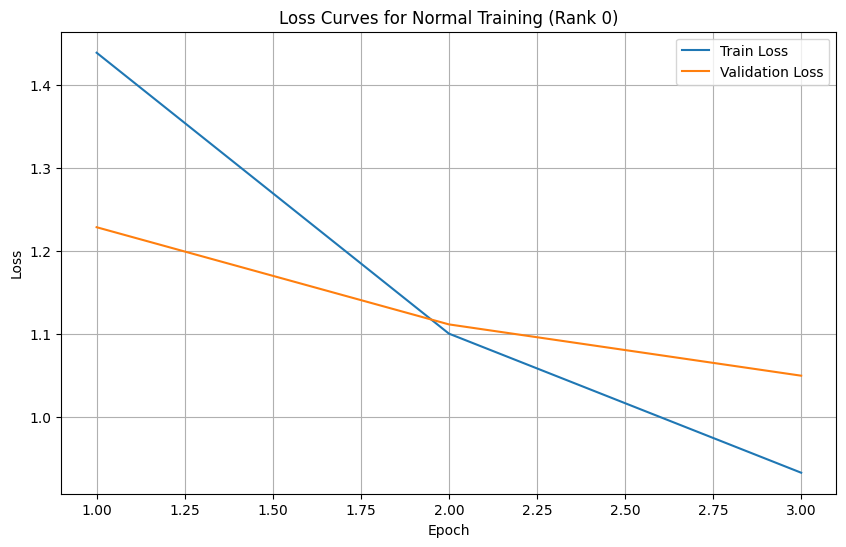

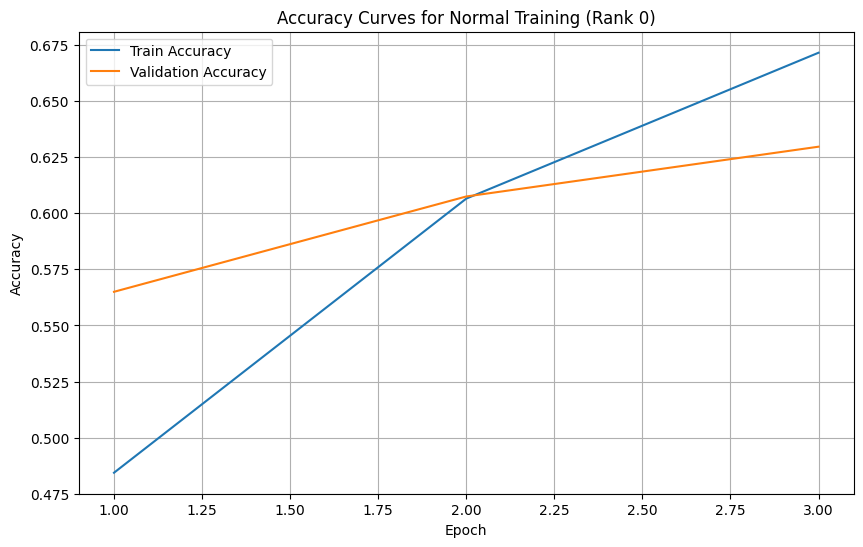

Test Loss: 1.0410, Test Accuracy: 0.6333

LoRA Training: Rank=2, Alpha=2, Learning Rate=0.001, Epochs=3


Epoch 1/3: Train Loss: 1.4272, Train Acc: 0.4873, Val Loss: 1.1913, Val Acc: 0.5804
Best model saved with loss: 1.1913


Epoch 2/3: Train Loss: 1.0823, Train Acc: 0.6168, Val Loss: 1.0481, Val Acc: 0.6305
Best model saved with loss: 1.0481


Epoch 3/3: Train Loss: 0.9066, Train Acc: 0.6822, Val Loss: 0.9936, Val Acc: 0.6537
Best model saved with loss: 0.9936


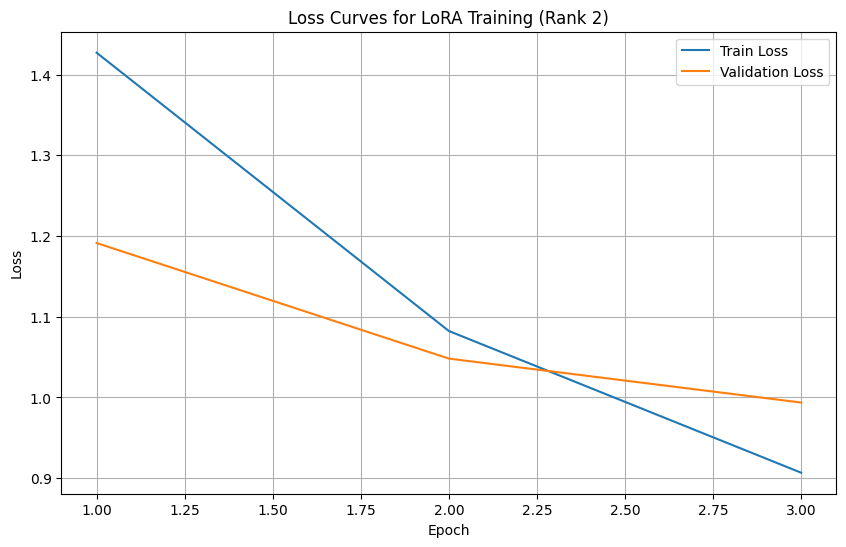

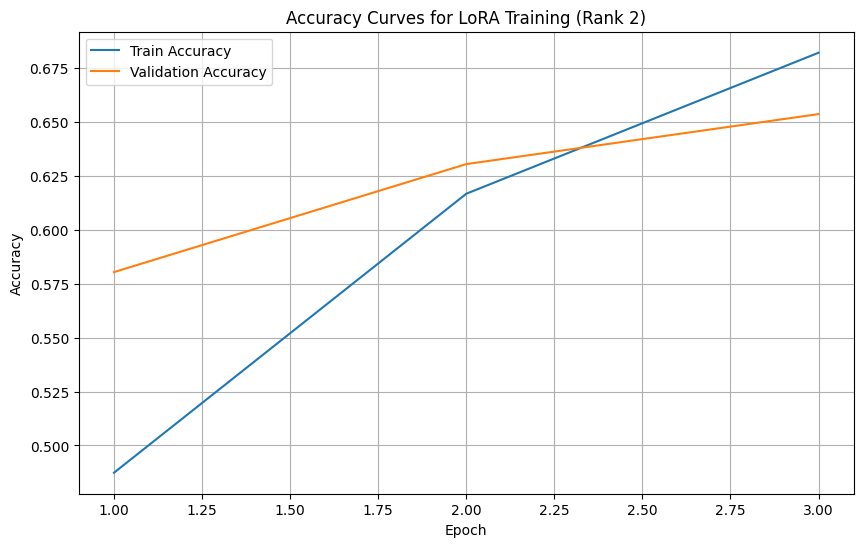

Test Loss: 0.9878, Test Accuracy: 0.6559


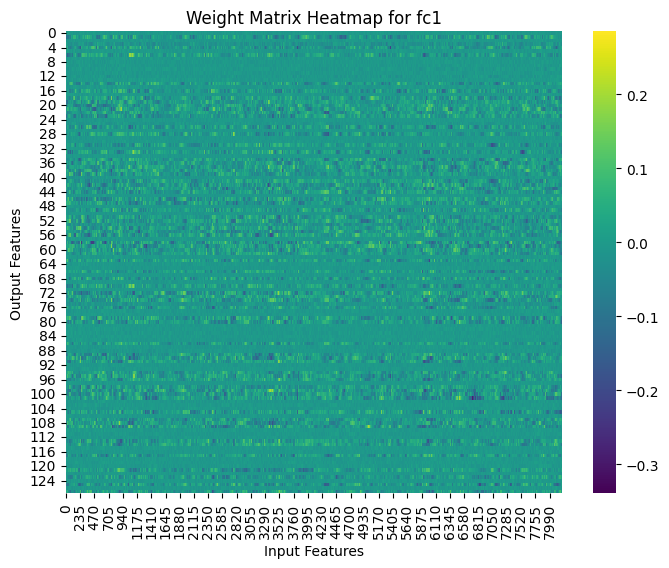

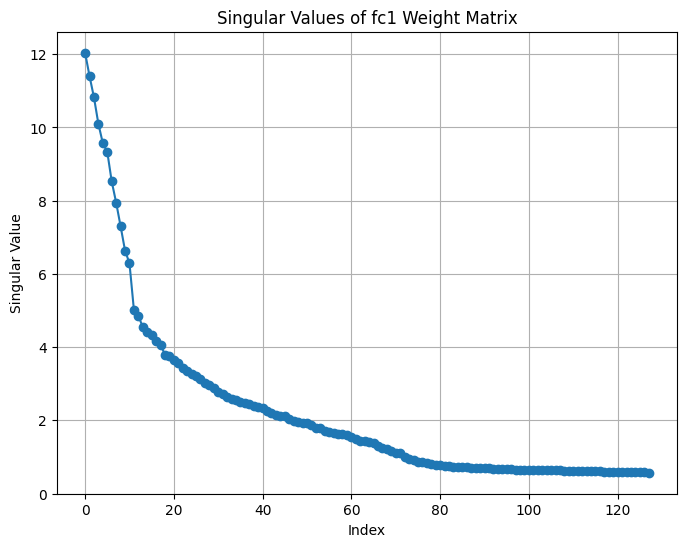


LoRA Training: Rank=4, Alpha=2, Learning Rate=0.001, Epochs=3


Epoch 1/3: Train Loss: 1.4292, Train Acc: 0.4873, Val Loss: 1.2091, Val Acc: 0.5672
Best model saved with loss: 1.2091


Epoch 2/3: Train Loss: 1.0796, Train Acc: 0.6183, Val Loss: 1.0522, Val Acc: 0.6220
Best model saved with loss: 1.0522


/tmp/ipykernel_127849/2727224912.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint.save_path))


Epoch 3/3: Train Loss: 0.8999, Train Acc: 0.6831, Val Loss: 0.9913, Val Acc: 0.6468
Best model saved with loss: 0.9913


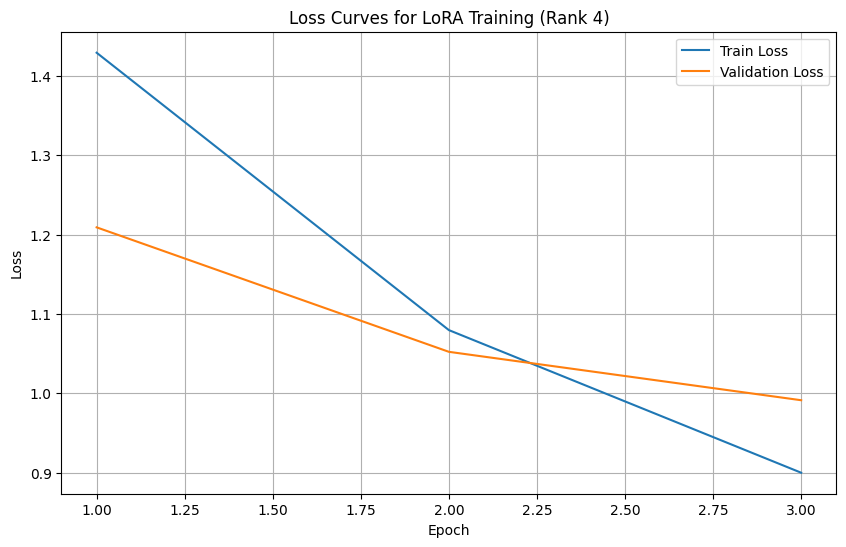

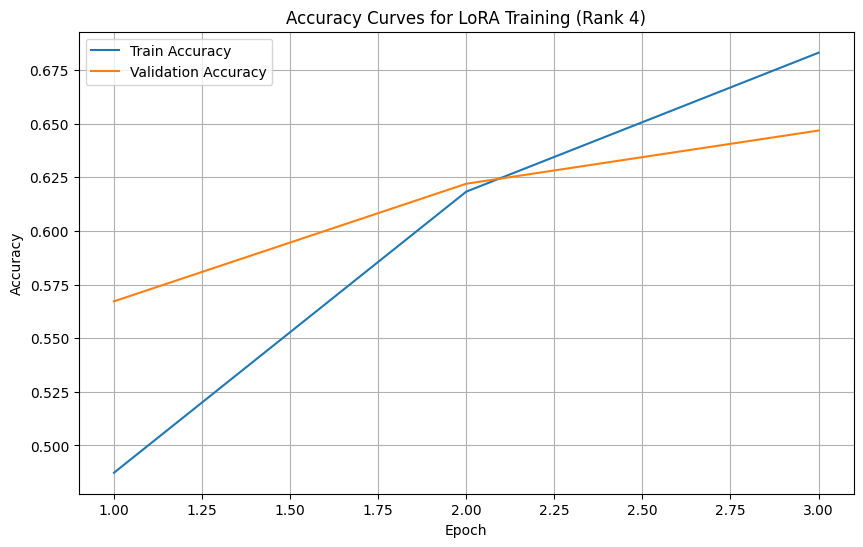

Test Loss: 0.9984, Test Accuracy: 0.6465


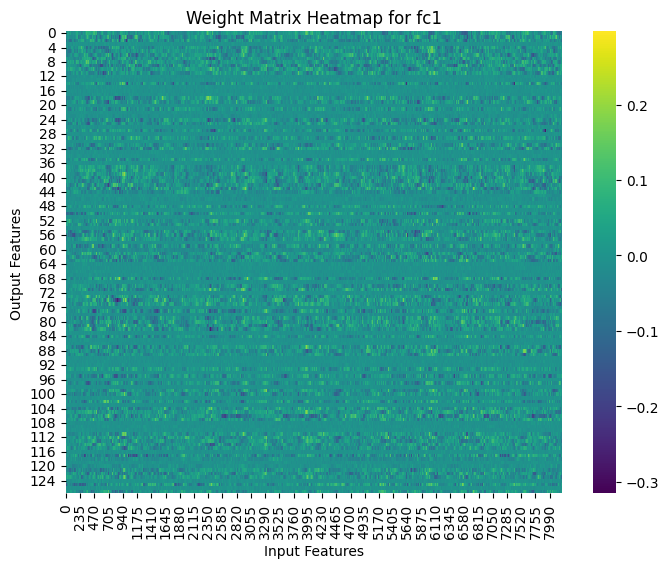

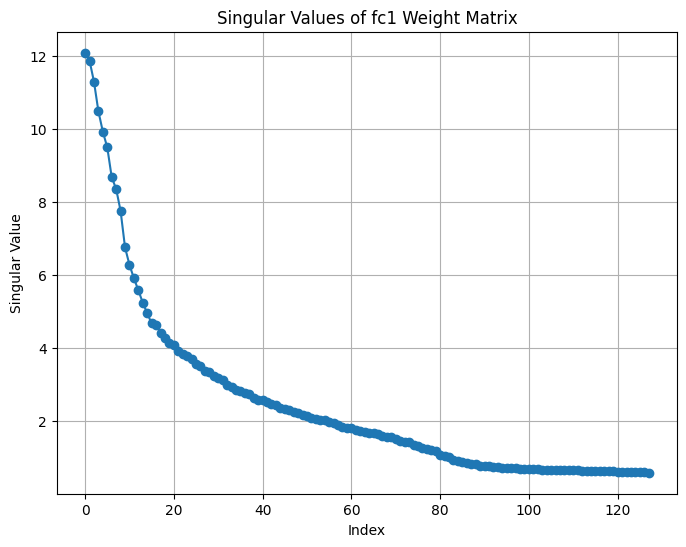


LoRA Training: Rank=8, Alpha=2, Learning Rate=0.001, Epochs=3


Epoch 1/3: Train Loss: 1.4603, Train Acc: 0.4787, Val Loss: 1.2553, Val Acc: 0.5521
Best model saved with loss: 1.2553


Epoch 2/3: Train Loss: 1.0985, Train Acc: 0.6100, Val Loss: 1.1078, Val Acc: 0.6064
Best model saved with loss: 1.1078


/tmp/ipykernel_127849/2727224912.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint.save_path))


Epoch 3/3: Train Loss: 0.9187, Train Acc: 0.6749, Val Loss: 1.0381, Val Acc: 0.6301
Best model saved with loss: 1.0381


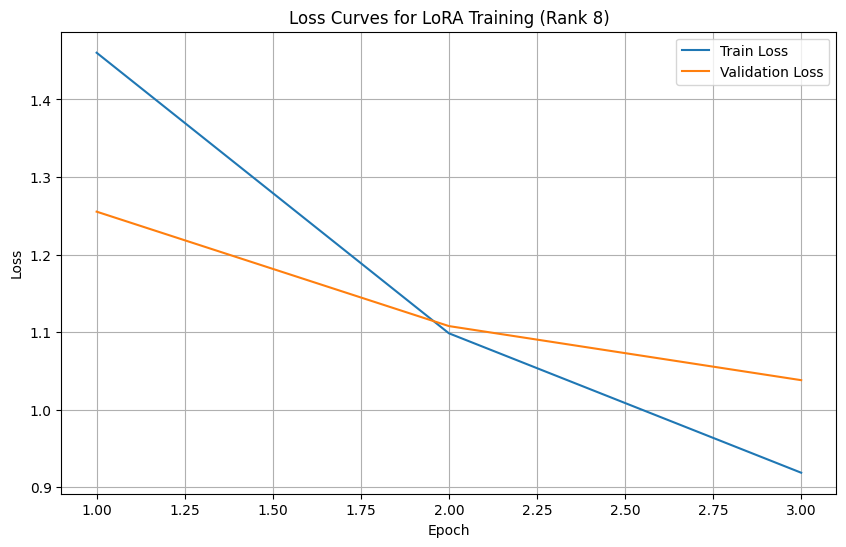

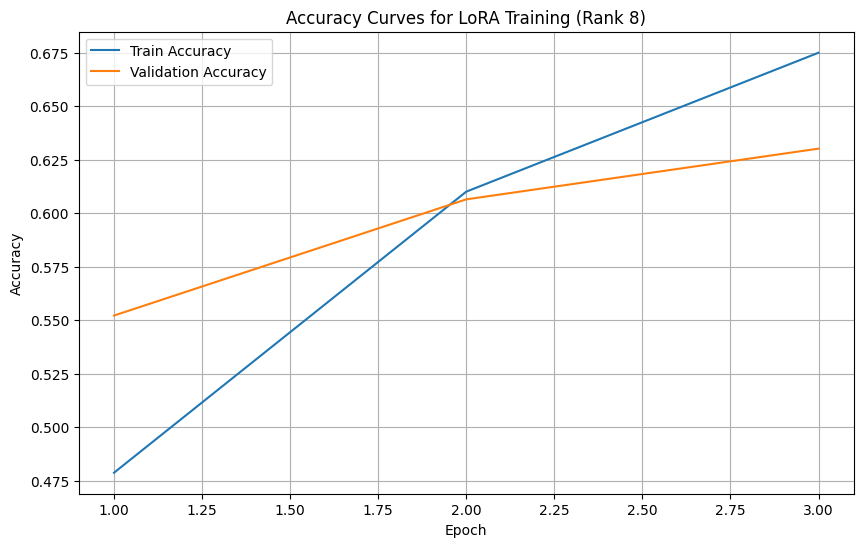

Test Loss: 1.0248, Test Accuracy: 0.6372


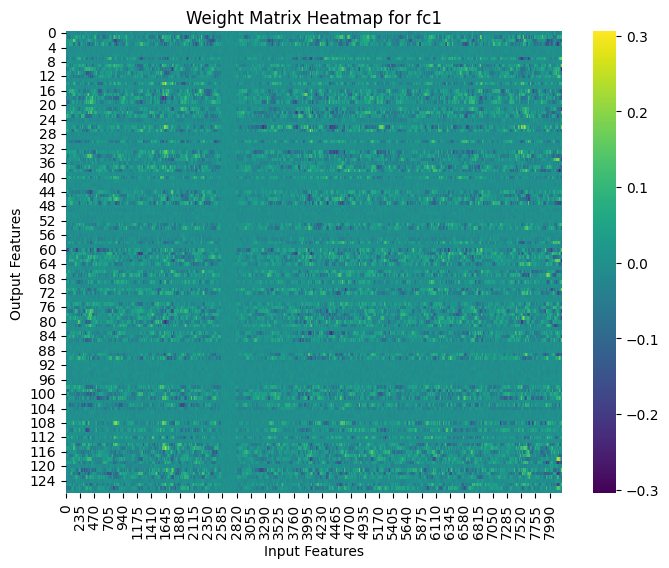

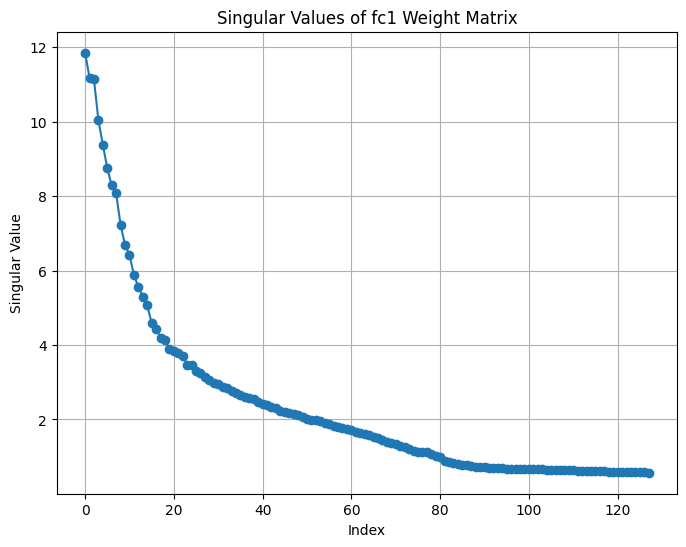


Scratch Training Results:


,rank,alpha,learning_rate,train_loss,val_loss,train_accuracy,val_accuracy,test_loss,test_accuracy
0,0,2,0.001,0.932785,1.049769,0.671600,0.6297,1.041017,0.6333
1,2,2,0.001,0.906647,0.993610,0.682175,0.6537,0.987789,0.6559
2,4,2,0.001,0.899885,0.991250,0.683075,0.6468,0.998392,0.6465
3,8,2,0.001,0.918717,1.038050,0.674925,0.6301,1.024756,0.6372


In [22]:
# Initialize a list to store results
scratch_experiment_results = []

# Iterate over different ranks
for rank in scratch_hyperparams['ranks']:
    if rank == 0:
        # Normal training without LoRA
        result = train_scratch_model(
            rank=rank,
            alpha=scratch_hyperparams['alpha'],
            learning_rate=scratch_hyperparams['learning_rate'],
            epochs=scratch_hyperparams['epochs']
        )
    else:
        # Training with LoRA
        result = train_scratch_model(
            rank=rank,
            alpha=scratch_hyperparams['alpha'],
            learning_rate=scratch_hyperparams['learning_rate'],
            epochs=scratch_hyperparams['epochs']
        )
    
    # Append the results
    scratch_experiment_results.append({
        'rank': rank,
        'alpha': scratch_hyperparams['alpha'],
        'learning_rate': scratch_hyperparams['learning_rate'],
        'train_loss': result['train_val_metrics']['train_loss'][-1],
        'val_loss': result['train_val_metrics']['val_loss'][-1],
        'train_accuracy': result['train_val_metrics']['train_acc'][-1],
        'val_accuracy': result['train_val_metrics']['val_acc'][-1],
        'test_loss': result['test_metrics']['test_loss'],
        'test_accuracy': result['test_metrics']['test_accuracy']
    })

# Convert results to DataFrame
scratch_results_df = pd.DataFrame(scratch_experiment_results)

# Display the results
print("\nScratch Training Results:")
display(scratch_results_df)


## 11. Experiment 2: Fine-tuning Pre-trained Models

Compare full fine-tuning vs. fine-tuning with LoRA on a pre-trained ResNet18 model. After each training run, plot the loss and accuracy curves and evaluate on the test set.

a. Fine-tuning Function Without LoRA (Full Fine-tuning)

In [23]:
def finetune_pretrained_model(rank=0, alpha=2, learning_rate=1e-4, epochs=10):
    """
    Fine-tunes a pre-trained ResNet18 model, optionally with LoRA.
    
    Args:
        rank (int): LoRA rank. 0 means no LoRA (full fine-tuning).
        alpha (int): LoRA alpha parameter.
        learning_rate (float): Learning rate.
        epochs (int): Number of training epochs.
    
    Returns:
        dict: Dictionary containing metrics and test results.
    """
    use_lora = rank != 0
    lora_rank = rank if use_lora else None
    lora_alpha = alpha if use_lora else None

    print(f"\n{'LoRA' if use_lora else 'Full Fine-tuning'}: Rank={rank}, Alpha={alpha}, Learning Rate={learning_rate}, Epochs={epochs}")
    
    model = get_pretrained_model(use_lora=use_lora, lora_rank=lora_rank, lora_alpha=lora_alpha, num_classes=10)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Define callbacks
    callbacks = {
        'early_stopping': EarlyStopping(patience=5),
        'model_checkpoint': ModelCheckpoint(save_path=f'best_finetune_rank{rank}.pth'),
        'lr_scheduler': LearningRateScheduler(optimizer, mode='min', factor=0.1, patience=3)
    }

    # Train the model
    trained_model, metrics = train_model(model, train_loader, val_loader, criterion, optimizer, callbacks, num_epochs=epochs)

    # Plot loss and accuracy curves
    plot_loss_curves(metrics, title=f'Loss Curves for {"LoRA" if use_lora else "Full Fine-tuning"} (Rank {rank})')
    plot_accuracy_curves(metrics, title=f'Accuracy Curves for {"LoRA" if use_lora else "Full Fine-tuning"} (Rank {rank})')

    # Evaluate on test set
    test_results = evaluate_model(trained_model, test_loader, criterion)

    # Visualize weight matrix and singular values for LoRA models
    if use_lora:
        visualize_weight_matrix(trained_model, layer_name='fc')
        plot_singular_values(trained_model, layer_name='fc')

    return {
        'train_val_metrics': metrics.history,
        'test_metrics': test_results
    }


## b. Running the Experiments

In [25]:
# Hyperparameters for Fine-tuning Pre-trained Models
finetune_hyperparams = {
    'epochs': 3,          # Number of training epochs
    'alpha': 2,            # LoRA alpha parameter
    'ranks': [0, 2, 4, 8], # List of ranks to experiment with (0 means no LoRA)
    'learning_rate': 1e-4  # Learning rate
}


Full Fine-tuning: Rank=0, Alpha=2, Learning Rate=0.0001, Epochs=3


/home/uumami/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/uumami/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/3: Train Loss: 0.5812, Train Acc: 0.8034, Val Loss: 0.3406, Val Acc: 0.8835
Best model saved with loss: 0.3406


Epoch 2/3: Train Loss: 0.2181, Train Acc: 0.9253, Val Loss: 0.3435, Val Acc: 0.8837


/tmp/ipykernel_127849/2727224912.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint.save_path))


Epoch 3/3: Train Loss: 0.1049, Train Acc: 0.9648, Val Loss: 0.3521, Val Acc: 0.8915


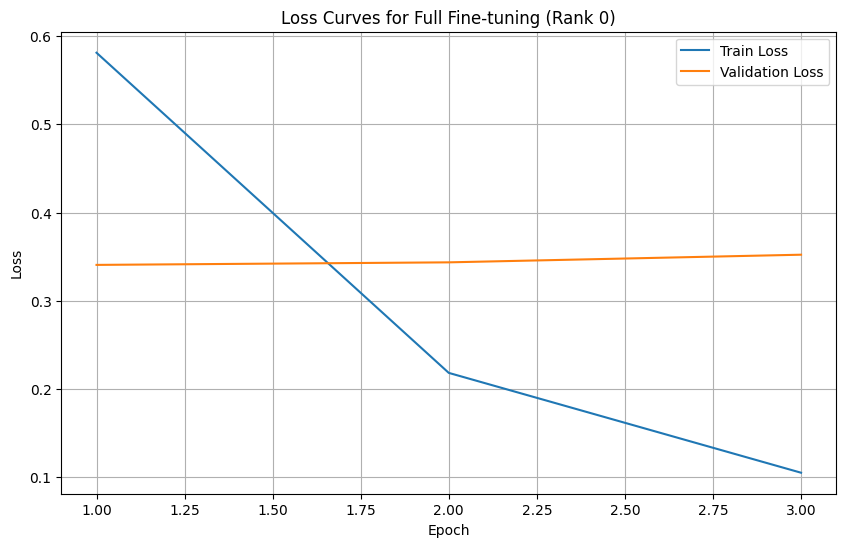

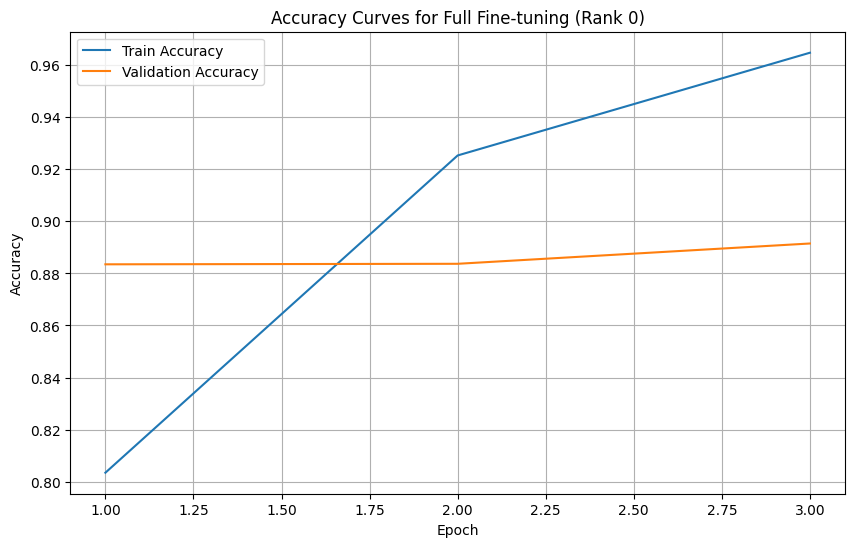

Test Loss: 0.3606, Test Accuracy: 0.8755

LoRA: Rank=2, Alpha=2, Learning Rate=0.0001, Epochs=3


Epoch 1/3: Train Loss: 0.5762, Train Acc: 0.8034, Val Loss: 0.3377, Val Acc: 0.8841
Best model saved with loss: 0.3377


Epoch 2/3: Train Loss: 0.2168, Train Acc: 0.9257, Val Loss: 0.3332, Val Acc: 0.8899
Best model saved with loss: 0.3332


Epoch 3/3: Train Loss: 0.1005, Train Acc: 0.9667, Val Loss: 0.3521, Val Acc: 0.8928


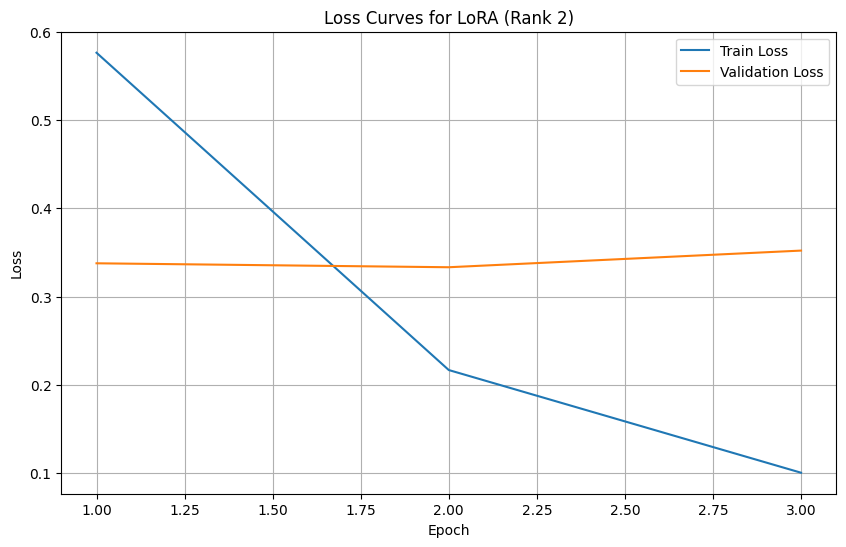

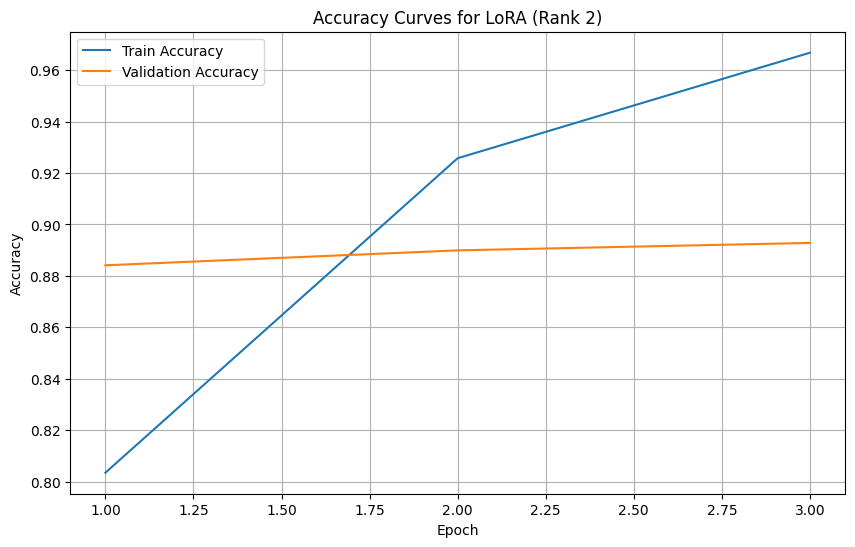

Test Loss: 0.3684, Test Accuracy: 0.8803


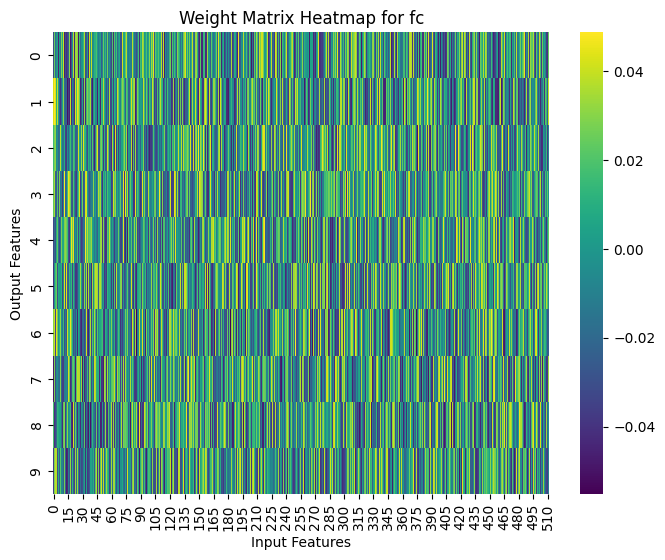

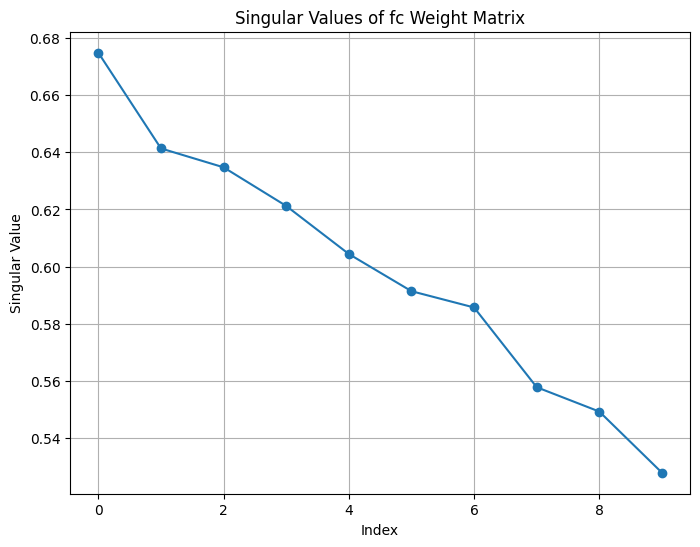


LoRA: Rank=4, Alpha=2, Learning Rate=0.0001, Epochs=3


/home/uumami/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/uumami/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/3: Train Loss: 0.5895, Train Acc: 0.8015, Val Loss: 0.3503, Val Acc: 0.8785
Best model saved with loss: 0.3503


Epoch 2/3: Train Loss: 0.2175, Train Acc: 0.9261, Val Loss: 0.3354, Val Acc: 0.8896
Best model saved with loss: 0.3354


/tmp/ipykernel_127849/2727224912.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint.save_path))


Epoch 3/3: Train Loss: 0.1048, Train Acc: 0.9640, Val Loss: 0.3590, Val Acc: 0.8894


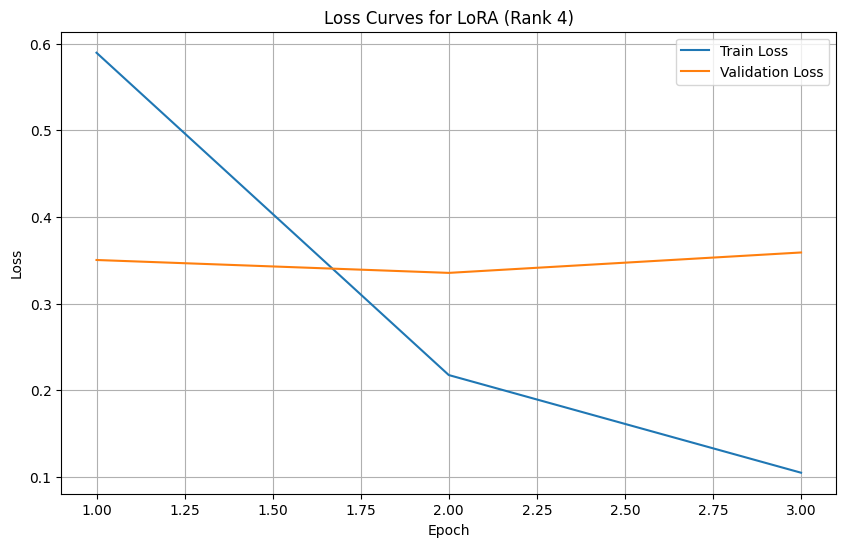

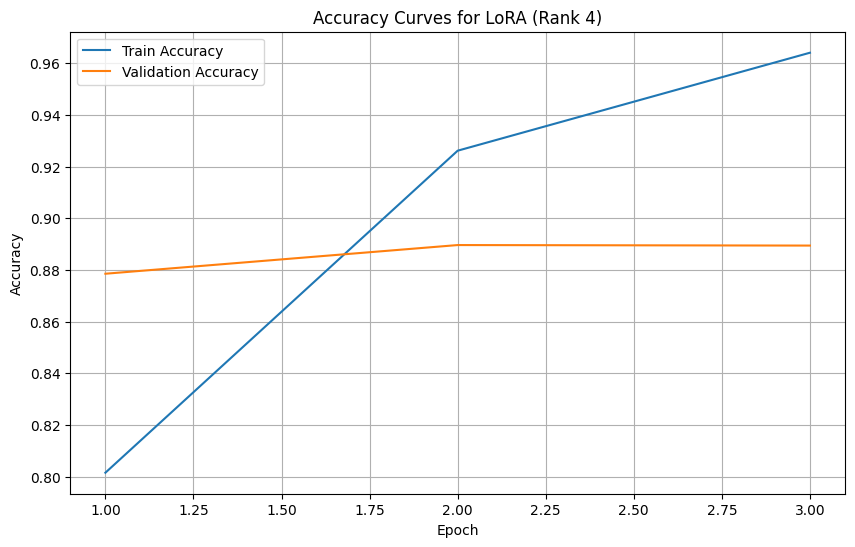

Test Loss: 0.3626, Test Accuracy: 0.8832


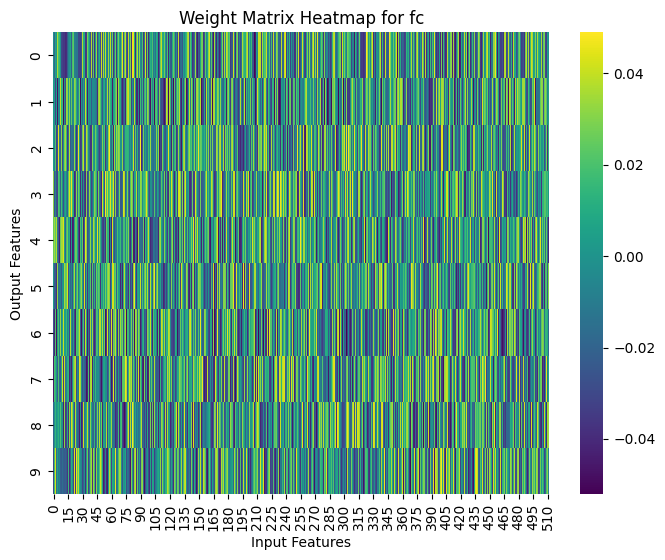

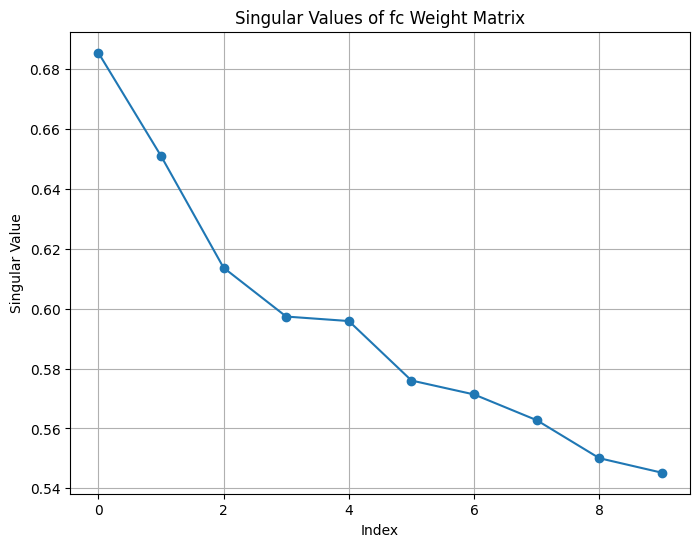


LoRA: Rank=8, Alpha=2, Learning Rate=0.0001, Epochs=3


/home/uumami/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/uumami/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/3: Train Loss: 0.5888, Train Acc: 0.7976, Val Loss: 0.3568, Val Acc: 0.8779
Best model saved with loss: 0.3568


Epoch 2/3: Train Loss: 0.2225, Train Acc: 0.9243, Val Loss: 0.3194, Val Acc: 0.8906
Best model saved with loss: 0.3194


Epoch 3/3 - Validation:  66%|██████▌   | 104/157 [00:03<00:01, 28.96it/s]

In [ ]:
# Initialize a list to store results
finetune_experiment_results = []

# Iterate over different ranks
for rank in finetune_hyperparams['ranks']:
    if rank == 0:
        # Full fine-tuning without LoRA
        result = finetune_pretrained_model(
            rank=rank,
            alpha=finetune_hyperparams['alpha'],
            learning_rate=finetune_hyperparams['learning_rate'],
            epochs=finetune_hyperparams['epochs']
        )
    else:
        # Fine-tuning with LoRA
        result = finetune_pretrained_model(
            rank=rank,
            alpha=finetune_hyperparams['alpha'],
            learning_rate=finetune_hyperparams['learning_rate'],
            epochs=finetune_hyperparams['epochs']
        )
    
    # Append the results
    finetune_experiment_results.append({
        'rank': rank,
        'alpha': finetune_hyperparams['alpha'],
        'learning_rate': finetune_hyperparams['learning_rate'],
        'train_loss': result['train_val_metrics']['train_loss'][-1],
        'val_loss': result['train_val_metrics']['val_loss'][-1],
        'train_accuracy': result['train_val_metrics']['train_acc'][-1],
        'val_accuracy': result['train_val_metrics']['val_acc'][-1],
        'test_loss': result['test_metrics']['test_loss'],
        'test_accuracy': result['test_metrics']['test_accuracy']
    })

# Convert results to DataFrame
finetune_results_df = pd.DataFrame(finetune_experiment_results)

# Display the results
print("\nFine-tuning Pre-trained Models Results:")
display(finetune_results_df)


# 12. Summary of Results

Compile and display all results in a consolidated manner for easy comparison.

In [ ]:
# Combine all results
all_results = pd.concat([scratch_results_df, finetune_results_df], ignore_index=True)

# Display combined results
print("\nAll Experiment Results:")
display(all_results)


In [ ]:
# Save the results to a CSV file for future reference
all_results.to_csv('experiment_results.csv', index=False)
print("Results saved to 'experiment_results.csv'")
